### Project Narration

Startup berbasis e-commerce, TokoPaedi, ingin mengetahui apakah dengan melakukan perubahan design pada website bisa meningkatkan conversion rate dan daya beli customer. Tim UI/UX, ditugaskan untuk membuat design baru, dan telah menghasilkan design baru yang potensial. Namun, sebelum menerapkannya pada tahap production, perusahaan ingin mengetahui apakah design baru ini memang benar-benar bisa meningkatkan conversion rate. Tim Data Science ditugaskan untuk melakukan pengujian terhadap design baru ini untuk memberikan rekomendasi terhadap perusahaan apakah design website yang baru layak diterapkan atau tim UI/UX perlu merevisi ulang design atau perusahaan cukup mempertahankan design yang lama. Untuk menguji hal ini, Teknik A/B Testing dipilih oleh Tim Data Science, karena selain cocok untuk case ini, Teknik A/B Testing tidak hanya membandingkan apakah satu hal lebih baik dari yang lain, namun juga membuktikan apakah perbedaan antara keduanya cukup signifikan secara statistik (statistically significant). Dalam melakukan pengujian ini, tim Data Science telah menetapkan nilai konfidensi sebesar 95%.

### Data Preparation

#### Import Library dan Packages

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math as mt
import itertools

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

font = {'family' : 'Poppins',
        'weight' : 'bold',
        'size'   : 16}

mpl.rc('font', **font)

/kaggle/input/ab-data/ab_data.csv


#### Impor Dataset

In [3]:
ab_data = pd.read_csv('../input/ab-data/ab_data.csv')
ab_df = ab_data.copy()

In [4]:
print('Dataset shape : ', ab_df.shape[0], 'rows &', ab_df.shape[1], 'columns')
ab_df.info()

Dataset shape :  294478 rows & 5 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
ab_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Dari dataset yang ada, akan digunakan dua macam grup user sebagai variabel independen, yang diberikan treatment berupa penyajian design website yang berbeda, yakni;
Control Group -> disajikan design lama
Treatment Group -> disajikan design baru

Alasan digunakannya dua grup adalah karena ingin mengontrol variabel lain yang dapat memengaruhi hasil. Dengan memiliki Control Group, hasil dapat langsung dibandingkan dengan Treatment Group, karena satu-satunya perbedaan sistematis antar grup adalah design website, dan karena itulah perbedaan hasil apa pun dapat dikaitkan dengan desain.

Untuk Variabel Dependen (yang akan diukur), akan digunakan Conversion Rate. Untuk melambangkan conversion rate akan digunakan bilangan biner pada tiap sesinya, dimana

0 -> User tidak membeli produk selama sesi/kunjungan mereka berlangsung

1 -> Pengguna membeli produk selama sesi berlangsung

### Memilih ukuran sampel
Penting untuk dicatat bahwa karena kami tidak akan menguji seluruh populasi / user, maka tingkat konversi yang akan kami dapatkan secara pasti hanya perkiraan dari tingkat sebenarnya.

Jumlah orang (atau sesi user) yang kami ditetapkan di setiap grup akan memengaruhi ketepatan taksiran conversion rate, dimana semakin besar ukuran sampel, maka semakin tepat taksiran (semakin kecil interval kepercayaan), dan semakin tinggi kesempatan untuk mendeteksi perbedaan dalam dua kelompok. Di sisi lain, semakin besar sampel yang digunakan, maka semakin mahal (dan tidak praktis) pengujian ini. 

Jadi berapa banyak orang yang harus kita miliki di setiap kelompok?

In [6]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Menghitung sample size yang dibutuhkan

required_n = ceil(required_n)                                             

print(required_n)

4720


Dibutuhkan setidaknya `4720` jumlah pengamatan untuk setiap kelompok dan memiliki peluang 90% untuk mengujinya secara signifikan

#### Data Cleaning

In [7]:
print('Jumlah Baris :', ab_df.shape[0])
print('Jumlah User unik :', ab_df['user_id'].nunique())

Jumlah Baris : 294478
Jumlah User unik : 290584


Diketahui bahwa terdapat perbedaan bahwa dari `294478` baris pada dataset, jumlah user yang unik ada sebanyak `290584` baris. Perlu kita cari tahu mengapa terjadi perbedaan ini

In [8]:
ab_df.duplicated().any()

False

In [9]:
# Jumlah user yang terduplikat
ab_df['user_id'].duplicated().sum()

3894

In [10]:
pd.crosstab(ab_df['group'], ab_df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Perbedaan jumlah antara user unik dan rows pada dataset, tidak disebabkan karena duplikasi row, melainkan karena adanya anomali. Anomali tersebut dapat dibuktikan dari crosstab, dimana tercatat `1928` group control mendapatkan treatment berupa penyajian design baru, dan `1965` group treatment yang mendapat penyajian design lama. Anomali ini perlu kita hilangkan, karena tidak sesuai dengan definisi testing.

In [11]:
anomali = ab_df[((ab_df['group']=='treatment')==(ab_df['landing_page']=='new_page'))==False].index

In [12]:
ab_df = ab_df.drop(anomali)

In [13]:
# hapus sekalian user_id yang duplikat
ab_df[ab_df['user_id'].duplicated(keep = False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
ab_df.drop([2893], axis =0, inplace = True)

In [15]:
print(f'Dataset sekarang memiliki {ab_df.shape[0]} baris')

Dataset sekarang memiliki 290584 baris


In [16]:
pd.crosstab(ab_df['group'], ab_df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145310,0


Dataset sekarang lebih bersih, dimana grup mendapat perlakuan sebagaimana mestinya (control grup disajikan design lama, treatment grup disajikan design baru)

### Sampling

Akan diambil sampel dengan jumlah yang diperlukan untuk pengujian. Untuk melakukan sampling, dapat menggunakan method DataFrame.sample() pada library pandas, yang akan melakukan Simple Random Sampling.

In [17]:
control_sample = ab_df[ab_df['group'] == 'control'].sample(n=required_n, random_state=22) 
treatment_sample = ab_df[ab_df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0
...,...,...,...,...,...
9435,688017,2017-01-12 11:50:30.520706,treatment,new_page,0
9436,699383,2017-01-18 23:14:20.245360,treatment,new_page,0
9437,724124,2017-01-13 18:12:31.235765,treatment,new_page,0
9438,695345,2017-01-13 20:57:14.879484,treatment,new_page,0


In [18]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

### Visualization

Hal pertama yang bisa dilakukan adalah dengan menghitung beberapa statistik dasar untuk mengetahui bentuk sample yang diambil.

In [19]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: ss.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.118,0.322,0.005


Dilihat dari statistik di atas, nampak bahwa kedua desain memiliki kinerja yang mirip, desain website yang lama, ternyata memiliki tingkat konversi rata-rata yang sedikit lebih baik.

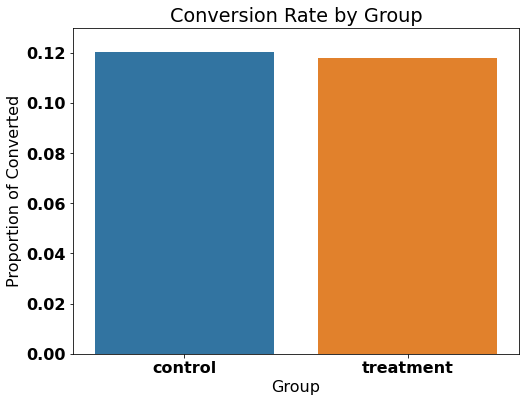

In [20]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.13)
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Proportion of Converted');

### Menguji Hipotesis

In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.38
p-value: 0.703
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.109, 0.127]


### Kesimpulan

Berdasarkan pengujian, p-value berada di atas ambang batas (0.05), maka Null Hipotesis Hₒ tidak dapat ditolak, yang berarti bahwa desain website yang baru tidak memiliki perbedaan kinerja yang statistically significant, (bahkan lebih buruk) daripada desain yang lama.
Dengan demikian, tim Data Sceince merekomendasikan untuk mempertahankan design lama, atau merevisi design baru, jika tetap ingin menyegarkan tampilan website.